# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Data preparation

### 1.1. Read data from file

In [48]:
#load the datasets (train data and test data which are pre-splitted)
data1 = MNIST(root='MNIST_dataset', train=True, download=True)
data2 = MNIST(root='MNIST_dataset', train=False, download=True)

#concatenate the data and labels from train and test datasets
all_images = torch.cat((data1.data, data2.data), dim=0)
all_labels = torch.cat((data1.targets, data2.targets), dim=0)

Now, we have 70,000 images in total.

In [49]:
x = all_images.numpy()
y = all_labels.numpy()

print("Total images:", x.shape[0])

Total images: 70000


### 1.2. Normalizing the data
Normalization is used for better gradient stability and faster convergence, so it's a crucial preprocessing step

In [50]:
x = x / 255.0  # Normalize pixel values to [0, 1] range

print("min pixel value:", x.min(), ", max pixel value:", x.max())

min pixel value: 0.0 , max pixel value: 1.0


### 1.3. Splitting into train, validataion and test sets
The use of `stratify=y` ensures that the proportion of each digit class (0-9) is maintained across all three subsets, preventing any class imbalance bias in the evaluation.

In [51]:
x_train, x_rest, y_train, y_rest = train_test_split(x, y, train_size= 0.6, random_state=42, stratify=y) # 60% train, 40% to split again into val and test
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.5, random_state=42, stratify=y_rest) # 40% * 50% = 20% val, 20% test

print("Training set = ", x_train.shape[0])
print("Validation set = ", x_val.shape[0])
print("Test set = ", x_test.shape[0])

Training set =  42000
Validation set =  14000
Test set =  14000


In [52]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Verify the new shape
print(f"Original shape: {x_train.shape}")
print(f"Flattened shape: {x_train_flat.shape}")

Original shape: (42000, 28, 28)
Flattened shape: (42000, 784)


### 1.4. Pytorch DataLoaders

- By setting `batch_size=64` and `shuffle=True` for the training set, we enable Stochastic Gradient Descent (SGD).
- Batch processing allows the model to compute gradients and update weights incrementally, which is faster and introduces necessary randomness to help the model escape local minima.

In [53]:
# Change from numpy arrays to tensors
x_train_tensor = torch.from_numpy(x_train_flat).unsqueeze(1).float()
y_train_tensor = torch.from_numpy(y_train).long()

x_val_tensor = torch.from_numpy(x_val_flat).unsqueeze(1).float()
y_val_tensor = torch.from_numpy(y_val).long()

x_test_tensor = torch.from_numpy(x_test_flat).unsqueeze(1).float()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders with batch size = 64 to optimize training
train_NN_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_NN_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_NN_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Linear Classification Models

## 2.1. Logistic Regression

For logistic regression, it's a binary classifier, so we need to use two digits only as classes.

### 2.1.1. Data preparation For Binary Classification

Boolean masking is used to filter the dataset for two specific digits.

In [54]:
def filter_digits(x, y, digit1, digit2):
    filter_mask = (y == digit1) | (y == digit2)

    x_filtered = x[filter_mask]
    y_filtered = y[filter_mask]

    y_filtered = np.where(y_filtered == digit1, 0, 1) # Map digit1 to 0 and digit2 to 1
    return x_filtered, y_filtered

Filter the data for only 2 digits.

In [55]:
DIGIT_A = 0
DIGIT_B = 1

x_binary_train_flat, y_binary_train = filter_digits(x_train_flat, y_train, DIGIT_A, DIGIT_B)
x_binary_val_flat, y_binary_val = filter_digits(x_val_flat, y_val, DIGIT_A, DIGIT_B)
x_binary_test_flat, y_binary_test = filter_digits(x_test_flat, y_test, DIGIT_A, DIGIT_B)

In [56]:
print(x_binary_train_flat.shape, y_binary_train.shape)
print(x_binary_val_flat.shape, y_binary_val.shape)
print(x_binary_test_flat.shape, y_binary_test.shape)

(8868, 784) (8868,)
(2957, 784) (2957,)
(2955, 784) (2955,)


In [57]:
# Convert to float tensors
# Convert labels to columns vector
x_train_binary_tensor = torch.from_numpy(x_binary_train_flat).float()
y_train_binary_tensor = torch.from_numpy(y_binary_train).float().view(-1, 1)

x_val_binary_tensor = torch.from_numpy(x_binary_val_flat).float()
y_val_binary_tensor = torch.from_numpy(y_binary_val).float().view(-1, 1)

x_test_binary_tensor = torch.from_numpy(x_binary_test_flat).float()
y_test_binary_tensor = torch.from_numpy(y_binary_test).float().view(-1, 1)

train_binary_dataset = torch.utils.data.TensorDataset(x_train_binary_tensor, y_train_binary_tensor)
val_binary_dataset = torch.utils.data.TensorDataset(x_val_binary_tensor, y_val_binary_tensor)
test_binary_dataset = torch.utils.data.TensorDataset(x_test_binary_tensor, y_test_binary_tensor)

train_lr_loader = DataLoader(train_binary_dataset, batch_size=64, shuffle=True)
val_lr_loader = DataLoader(val_binary_dataset, batch_size=64, shuffle=False)
test_lr_loader = DataLoader(test_binary_dataset, batch_size=64, shuffle=False)

### 2.1.2. Defining The Model

In [58]:
INPUT_FEATURES = 784 # Number of pixels/inputs (28x28)
OUTPUT_FEATURES = 1  # The output is either 0 or 1

# Create the weights tensor of random numbers with size of (784, 1)
weights = torch.randn(INPUT_FEATURES, OUTPUT_FEATURES, dtype=torch.float)

# Create the bias tensor of zeros with size of 1 element
bias = torch.zeros(OUTPUT_FEATURES, dtype=torch.float)

# Enable gradient tracking for weights and bias
weights.requires_grad = True
bias.requires_grad = True

Define Sigmoid activation function and the binary cross entropy loss function.

In [59]:
def sigmoid(z):
    return 1.0 / (1.0 + torch.exp(-z))

# y_true are the labels (0 or 1) and y_pred_logits are the model outputs (logits)
def binary_cross_entropy_loss(y_true, y_pred_logits):

    p = sigmoid(y_pred_logits)
    
    # Prevent log(0) by adding a small value (epsilon)
    epsilon = 1e-7

    loss_per_item = - ( y_true * torch.log(p + epsilon) + (1.0 - y_true) * torch.log(1.0 - p + epsilon) )

    # Return average
    return torch.mean(loss_per_item)

### 2.1.3 Training The Model

In [60]:
learning_rate = 0.01
num_epochs = 100

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    correct, total, epoch_loss = 0,0,0

    for x_batch, y_batch in train_lr_loader:
        # Forward Pass
        logits = x_batch @ weights + bias

        loss = binary_cross_entropy_loss(y_batch, logits)
        loss.backward()

        with torch.no_grad():
            weights -= learning_rate * weights.grad
            bias -= learning_rate * bias.grad

        # Reset Gradients
        weights.grad.zero_()
        bias.grad.zero_()

        # Track Loss
        epoch_loss += loss.item() * x_batch.size(0)

        # Compute Accuracy
        predictions = (sigmoid(logits) >= 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += x_batch.size(0)

    train_losses.append(epoch_loss / total)
    train_accuracies.append(correct / total)

    # Validation
    with torch.no_grad():
        val_logits = x_val_binary_tensor @ weights + bias
        val_predictions = sigmoid(val_logits)
        val_loss = binary_cross_entropy_loss(y_val_binary_tensor, val_logits)
        val_losses.append(val_loss.item())

        val_pred_labels = (val_predictions >= 0.5).float()
        val_accuracy = (val_pred_labels == y_val_binary_tensor).float().mean().item()
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]*100:.2f}% | "
          f"Val Acc: {val_accuracies[-1]*100:.2f}%")

Epoch 1/100 | Train Loss: 0.6260 | Train Acc: 81.20% | Val Acc: 88.47%
Epoch 2/100 | Train Loss: 0.2773 | Train Acc: 90.91% | Val Acc: 93.24%
Epoch 3/100 | Train Loss: 0.1768 | Train Acc: 94.28% | Val Acc: 95.37%
Epoch 4/100 | Train Loss: 0.1323 | Train Acc: 95.90% | Val Acc: 96.42%
Epoch 5/100 | Train Loss: 0.1074 | Train Acc: 96.71% | Val Acc: 96.96%
Epoch 6/100 | Train Loss: 0.0917 | Train Acc: 97.25% | Val Acc: 97.40%
Epoch 7/100 | Train Loss: 0.0807 | Train Acc: 97.61% | Val Acc: 97.70%
Epoch 8/100 | Train Loss: 0.0726 | Train Acc: 97.87% | Val Acc: 98.04%
Epoch 9/100 | Train Loss: 0.0664 | Train Acc: 98.08% | Val Acc: 98.24%
Epoch 10/100 | Train Loss: 0.0615 | Train Acc: 98.38% | Val Acc: 98.44%
Epoch 11/100 | Train Loss: 0.0575 | Train Acc: 98.48% | Val Acc: 98.48%
Epoch 12/100 | Train Loss: 0.0542 | Train Acc: 98.61% | Val Acc: 98.61%
Epoch 13/100 | Train Loss: 0.0513 | Train Acc: 98.67% | Val Acc: 98.82%
Epoch 14/100 | Train Loss: 0.0489 | Train Acc: 98.67% | Val Acc: 98.92%
E

### 2.1.4 Loss & Accuracy Curves for Training and Validation
The binary logistic regression model for classifying digits 0 vs 1 converges very **quickly** and **smoothly** demonastrating that two classes are **highly linearly separable**.

The training and validation curves track closely, indicating minimal to no overfitting.



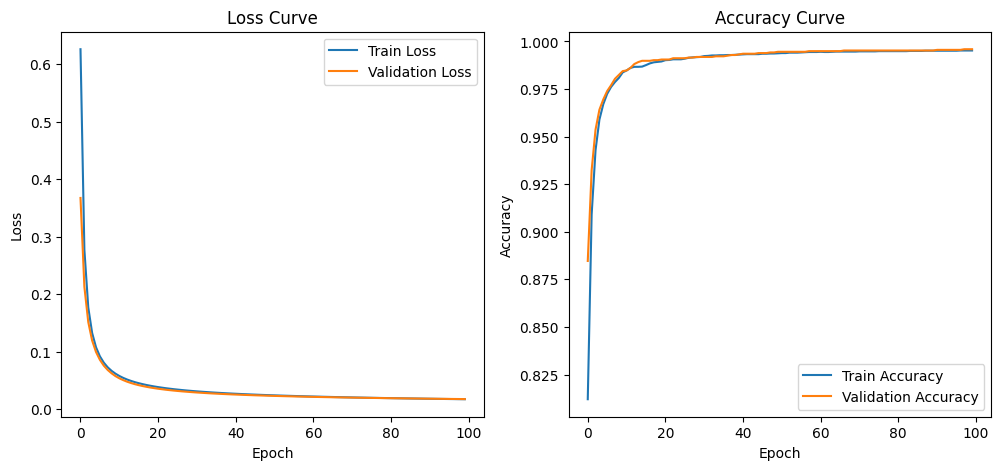

In [61]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 2.1.5 Test Accuracy & Confusion Matrix
This excellent result is expected for the relatively easy task of distinguishing between the highly distinct shapes of '0' and '1'.


Test Accuracy: 99.29%


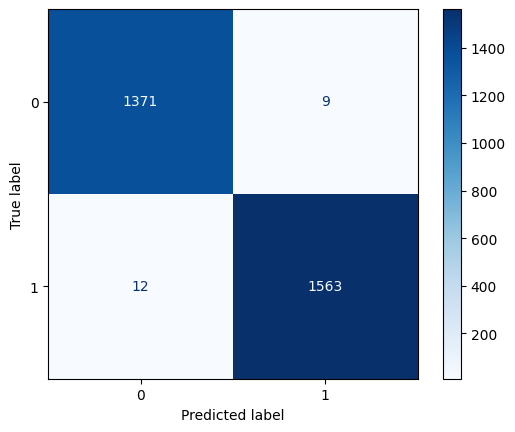

In [62]:
with torch.no_grad():
    test_logits = x_test_binary_tensor @ weights + bias
    test_predictions = (sigmoid(test_logits) >= 0.5).float()

test_accuracy = (test_predictions == y_test_binary_tensor).float().mean().item()
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

cm = confusion_matrix(y_test_binary_tensor.numpy(), test_predictions.numpy())
ConfusionMatrixDisplay(cm, display_labels=[DIGIT_A, DIGIT_B]).plot(cmap="Blues")
plt.show()

## 2.2. SoftMax Regression

### 2.2.1. Data preparation For Multi-class Classification

Already done in the previous section


### 2.2.2 Defining the Model

In [63]:
INPUT_FEATURES = 784 # Number of pixels/inputs (28x28)
NUM_CLASSES = 10 # The output may differ from 0 to 9

# Create the weights tensor of random numbers with size of (784, 10)
weights_soft = torch.randn(INPUT_FEATURES, NUM_CLASSES, dtype=torch.float)

# Create the bias tensor of zeros with size of 10 elements
bias_soft = torch.zeros(NUM_CLASSES, dtype=torch.float)

# Enable gradient tracking for weights and bias
weights_soft.requires_grad = True
bias_soft.requires_grad = True

Define Softmax Function & Cross Entropy Loss

In [64]:
def softmax(logits):
    exp_scores = torch.exp(logits)
    return exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

def softmax_cross_entropy_loss(y_true, logits):
    # Apply softmax to get probabilities
    probs = softmax(logits)

    # eps to avoid log(0)
    epsilon = 1e-7
    correct_log_probs = -torch.log(probs[range(len(y_true)), y_true] + epsilon)

    return torch.mean(correct_log_probs), probs

### 2.2.3. Training The Model

In [65]:
learning_rate = 0.01
num_epochs = 100

train_soft_losses, val_soft_losses, train_soft_accuracies, val_soft_accuracies = [], [], [], []

for epoch in range(num_epochs):
    correct, total, epoch_loss = 0,0,0

    for x_batch, y_batch in train_NN_loader:
        # Forward Pass
        x_batch = x_batch.squeeze(1)
        y_batch = y_batch.long().view(-1)
        logits = x_batch @ weights_soft + bias_soft

        loss, probs = softmax_cross_entropy_loss(y_batch, logits)
        loss.backward()

        with torch.no_grad():
            weights_soft -= learning_rate * weights_soft.grad
            bias_soft -= learning_rate * bias_soft.grad

        # Reset Gradients
        weights_soft.grad.zero_()
        bias_soft.grad.zero_()

        # Track Loss
        epoch_loss += loss.item() * x_batch.size(0)

        # Compute Accuracy
        correct += (probs.argmax(dim=1) == y_batch).sum().item()
        total += x_batch.size(0)

    train_soft_losses.append(epoch_loss / total)
    train_soft_accuracies.append(correct / total)

    # Validation
    with torch.no_grad():
        val_logits = x_val_tensor.squeeze(1) @ weights_soft + bias_soft
        y_val_indices = y_val_tensor.long().view(-1)
        val_loss, val_probs = softmax_cross_entropy_loss(y_val_indices, val_logits)

        val_soft_losses.append(val_loss.item())
        val_soft_accuracies.append((val_probs.argmax(1) == y_val_indices).float().mean().item())

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_soft_accuracies[-1]*100:.2f}% | Val Acc: {val_soft_accuracies[-1]*100:.2f}%")


Epoch 1/100 | Train Acc: 22.68% | Val Acc: 32.48%
Epoch 2/100 | Train Acc: 39.12% | Val Acc: 44.99%
Epoch 3/100 | Train Acc: 49.16% | Val Acc: 53.16%
Epoch 4/100 | Train Acc: 56.74% | Val Acc: 60.40%
Epoch 5/100 | Train Acc: 62.39% | Val Acc: 65.07%
Epoch 6/100 | Train Acc: 66.51% | Val Acc: 68.69%
Epoch 7/100 | Train Acc: 69.54% | Val Acc: 70.94%
Epoch 8/100 | Train Acc: 71.72% | Val Acc: 72.84%
Epoch 9/100 | Train Acc: 73.55% | Val Acc: 74.25%
Epoch 10/100 | Train Acc: 75.10% | Val Acc: 75.28%
Epoch 11/100 | Train Acc: 76.21% | Val Acc: 76.26%
Epoch 12/100 | Train Acc: 77.24% | Val Acc: 77.24%
Epoch 13/100 | Train Acc: 78.05% | Val Acc: 77.94%
Epoch 14/100 | Train Acc: 78.73% | Val Acc: 78.61%
Epoch 15/100 | Train Acc: 79.33% | Val Acc: 79.09%
Epoch 16/100 | Train Acc: 79.89% | Val Acc: 79.59%
Epoch 17/100 | Train Acc: 80.39% | Val Acc: 80.06%
Epoch 18/100 | Train Acc: 80.84% | Val Acc: 80.59%
Epoch 19/100 | Train Acc: 81.22% | Val Acc: 81.00%
Epoch 20/100 | Train Acc: 81.64% | Val A

### 2.2.4. Loss & Accuracy Curves for Training and Validation
The 10-class Softmax Regression problem is significantly more challenging than the binary task. As shown by the curves, the model's convergence is **slower**, and the final accuracy is **substantially lower**.

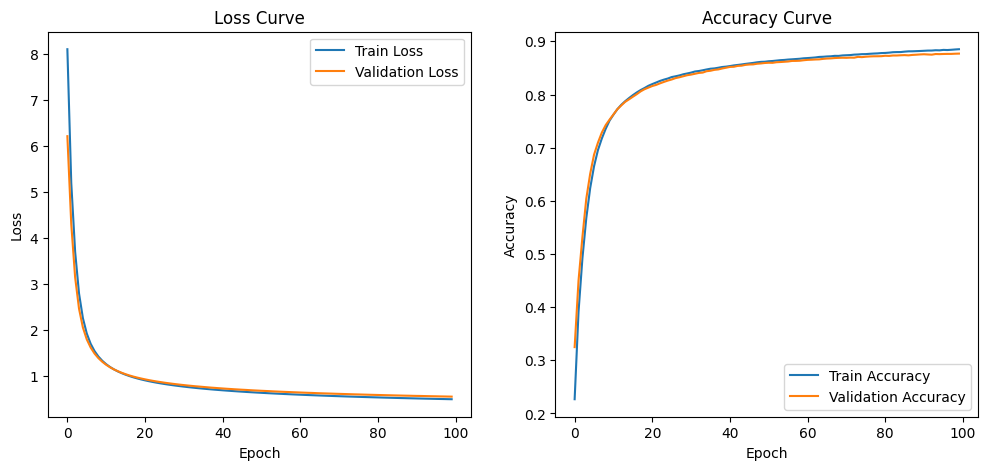

In [66]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_soft_losses, label="Train Loss")
plt.plot(val_soft_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_soft_accuracies, label="Train Accuracy")
plt.plot(val_soft_accuracies, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 2.1.5 Test Accuracy & Confusion Matrix
Per-class analysis reveals uneven performance, which highlights the difficulty of distinguishing certain digits:
- Highest Accuracy: Digit 1 ($95.68\%$) and 6 ($94.11\%$) are classified with high confidence, likely due to their distinct and relatively simple shapes.
- Lowest Accuracy: Digits 5 ($78.46\%$) and 8 ($80.81\%$) are the most challenging, as their shapes can easily overlap with other classes _(3, 6, 9)_ when represented only by flattened pixel values.

Test Accuracy: 87.75%

Per-Class Accuracy:
Digit 0: 94.28%
Digit 1: 95.68%
Digit 2: 86.77%
Digit 3: 84.32%
Digit 4: 88.94%
Digit 5: 78.46%
Digit 6: 94.11%
Digit 7: 88.83%
Digit 8: 80.81%
Digit 9: 83.47%


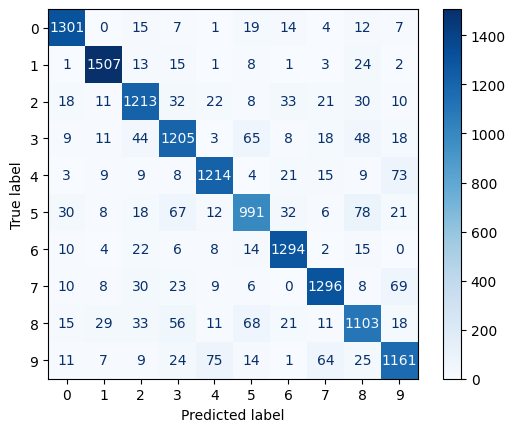

In [83]:
with torch.no_grad():
    x_test_flat = x_test_tensor.squeeze(1)      # shape [N,784]
    y_test_idx = y_test_tensor.long().view(-1)  # shape [N]
    # Forward Pass (logits)
    test_logits = x_test_flat @ weights_soft + bias_soft # shape [N, 10]
    # Numerical-stable softmax
    test_probs = softmax(test_logits)    # Predicted class = index of max probability
    test_pred_labels = test_probs.argmax(dim=1)

# Compute Accuracy
test_accuracy = (test_pred_labels == y_test_idx).float().mean().item()
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Per-Class Accuracy Analysis
print("\nPer-Class Accuracy:")
for digit in range(10):
    mask = (y_test_idx == digit)
    correct = (test_pred_labels[mask] == digit).sum().item()
    total = mask.sum().item()
    acc = correct / total if total > 0 else 0
    print(f"Digit {digit}: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test_idx.numpy(), test_pred_labels.numpy(), labels=list(range(10)))
ConfusionMatrixDisplay(cm, display_labels=list(range(10))).plot(cmap="Blues")
plt.show()

### 2.1.6. PyTorch Built-In Model Comparison

In [88]:
# PyTorch Softmax Regression Model (Linear Layer Only)
model = nn.Linear(INPUT_FEATURES, NUM_CLASSES)
# Loss and Optimizer, same settings as manual model
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the PyTorch built-in model
for epoch in range(5): # 5 epochs is enough for comparison
    correct, total = 0, 0
    for x_batch, y_batch in train_NN_loader:
        x_batch = x_batch.squeeze(1)
        y_batch = y_batch.long()

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        correct += (logits.argmax(dim=1) == y_batch).sum().item()
        total += x_batch.size(0)

    print(f"Built-in Model Epoch {epoch+1} | Train Accuracy: {correct/total*100:.2f}%")


# Evaluate built-in model
with torch.no_grad():
    x_test_flat = x_test_tensor.squeeze(1)
    logits = model(x_test_flat)
    preds = logits.argmax(dim=1)

baseline_acc = (preds == y_test_tensor).float().mean().item()
print(f"PyTorch Built-In Softmax Test Accuracy: {baseline_acc*100:.2f}%")
print(f"Manual Implementation Test Accuracy: {test_accuracy*100:.2f}%")


Built-in Model Epoch 1 | Train Accuracy: 78.29%
Built-in Model Epoch 2 | Train Accuracy: 86.08%
Built-in Model Epoch 3 | Train Accuracy: 87.44%
Built-in Model Epoch 4 | Train Accuracy: 88.17%
Built-in Model Epoch 5 | Train Accuracy: 88.72%
PyTorch Built-In Softmax Test Accuracy: 88.61%
Manual Implementation Test Accuracy: 87.75%


# 3. Neural Network model
### 3.1. Feed Forward NN

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, number_hidden_layers, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for i in range(number_hidden_layers-1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))

        self.weight_initialization()

    def weight_initialization(self):
        # He initialization
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, nonlinearity= 'relu')

                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):

        x = x.view(x.size(0), -1) # flatten input (28x28 to 784)

        for layer in self.layers[:-1]:
            x = F.relu(layer(x))

        x = self.layers[-1](x)

        return x

### 3.2. Training the NN model

In [ ]:
def training_infrastructure (train_dataset, val_dataset, NUMBER_HIDDEN_LAYERS, HIDDEN_SIZE, LEARNING_RATE, BATCH_SIZE, NUM_EPOCHS):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for gpu acceleration
    print(f"Using {device}") #check if gpu acceleration is working

    INPUT_SIZE = 784
    OUTPUT_SIZE = 10

    training_losses = []
    training_accurices = []
    validation_losses = []
    validation_accurices = []

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = FeedForwardNN(INPUT_SIZE, NUMBER_HIDDEN_LAYERS, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    loss_function = nn.CrossEntropyLoss()

    num_total_steps = len(train_loader)
    for epoch in range(NUM_EPOCHS):

        # training loop
        model.train()
        current_train_loss = 0
        total = 0
        correct = 0

        for i, (image, label) in enumerate(train_loader):
            image = image.to(device)
            label = label.to(device)

            #forward
            outputs = model(image)
            loss = loss_function(outputs, label)
            current_train_loss += loss.item()

            #bacward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

        average_train_loss = current_train_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        training_losses.append(average_train_loss)
        training_accurices.append(train_accuracy)

        #validation loop
        model.eval()
        current_val_loss = 0
        total = 0
        correct = 0

        with torch.no_grad():
            for i, (image, label) in enumerate(val_loader):
                image = image.to(device)
                label = label.to(device)

                #forward
                outputs = model(image)
                loss = loss_function(outputs, label)
                current_val_loss += loss.item()

                #calc accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
        #calculate average validation loss and accuracy
        average_val_loss = current_val_loss / len(val_loader)
        validation_accuracy = 100 * correct / total

        validation_losses.append(average_val_loss)
        validation_accurices.append(validation_accuracy)
        print(f"Epoch: {epoch+1} / {NUM_EPOCHS} | avg train loss: {average_train_loss:.4f} | train accuracy : {train_accuracy:.2f}|avg validation loss: {average_val_loss:.4f} | validation accuracy: {validation_accuracy:.2f} ")

    return training_losses, validation_losses, training_accurices, validation_accurices, model

we'll train the model 5 times to be able to analyize the learning curve wit error bars.

In [ ]:
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

for i in range (5) :
    print(f"call: {i+1} / 5 \n")
    train_loss, val_loss, train_acc, val_acc, NN_model= training_infrastructure(train_dataset, val_dataset, 2, 64, 0.01, 64, 40)

    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

call: 1 / 5 

Using cuda
Epoch: 1 / 40 | avg train loss: 0.9283 | train accuracy : 75.35|avg validation loss: 0.4611 | validation accuracy: 87.42 
Epoch: 2 / 40 | avg train loss: 0.3905 | train accuracy : 88.97|avg validation loss: 0.3637 | validation accuracy: 89.46 
Epoch: 3 / 40 | avg train loss: 0.3230 | train accuracy : 90.77|avg validation loss: 0.3123 | validation accuracy: 91.06 
Epoch: 4 / 40 | avg train loss: 0.2878 | train accuracy : 91.75|avg validation loss: 0.2876 | validation accuracy: 91.56 
Epoch: 5 / 40 | avg train loss: 0.2631 | train accuracy : 92.39|avg validation loss: 0.2678 | validation accuracy: 92.36 
Epoch: 6 / 40 | avg train loss: 0.2432 | train accuracy : 93.04|avg validation loss: 0.2519 | validation accuracy: 92.73 
Epoch: 7 / 40 | avg train loss: 0.2274 | train accuracy : 93.50|avg validation loss: 0.2414 | validation accuracy: 92.94 
Epoch: 8 / 40 | avg train loss: 0.2135 | train accuracy : 93.86|avg validation loss: 0.2318 | validation accuracy: 93.36 

### 3.3. Training VS Validation plots

#### 3.3.1. Loss X epochs graph

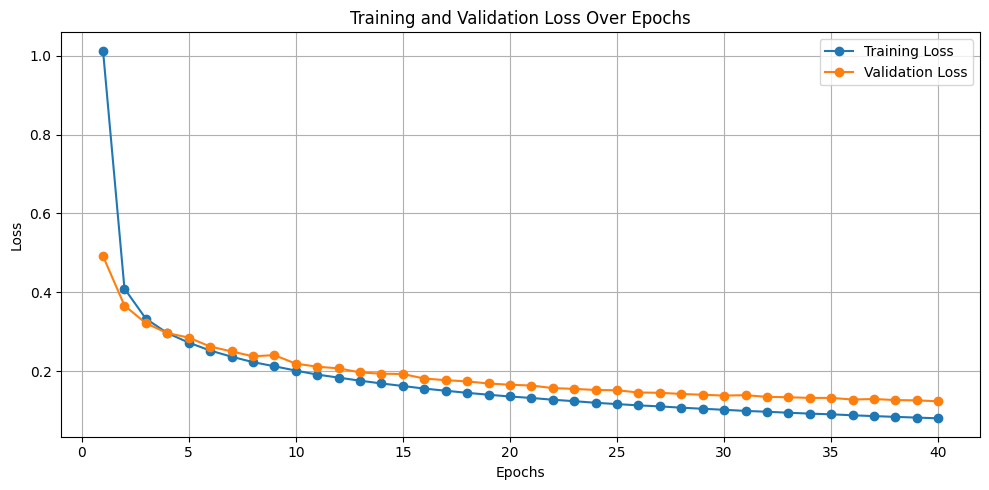

In [ ]:
# val - train loss plot
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

#### 3.3.2. Accuracy X epochs

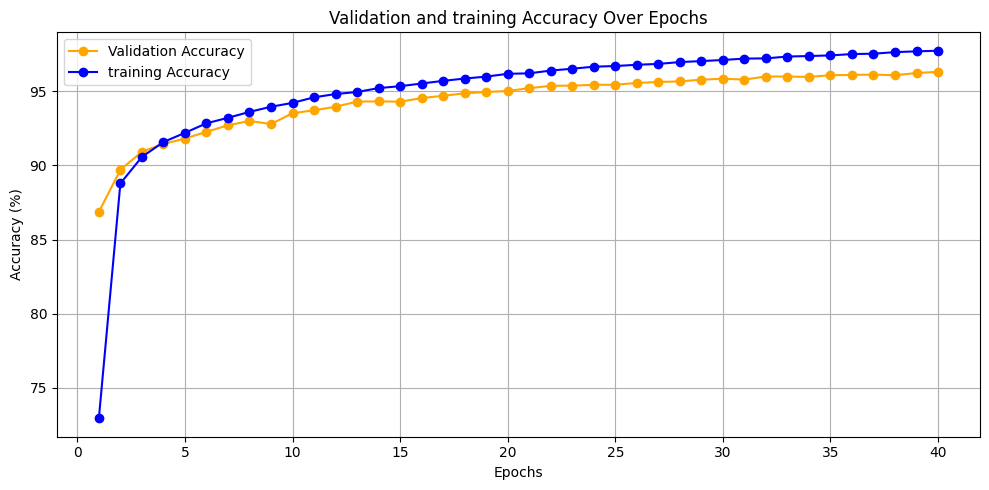

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy', color='orange')
plt.plot(epochs, train_acc, 'o-', label='training Accuracy', color='blue')
plt.title('Validation and training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()

#### 3.3.3. Learning curve with error bars

3.3.3.1. Calculating the mean and standard deviation for each epoch

In [ ]:
#change the lists to numpy lists
train_loss_np = np.array(all_train_loss)
train_acc_np = np.array(all_train_acc)
val_loss_np = np.array(all_val_loss)
val_acc_np = np.array(all_val_acc)

#calculate mean and std foe both val and train losses and accuracies
mean_train_loss = np.mean(train_loss_np, axis=0)
std_train_loss = np.std(train_loss_np, axis=0)

mean_val_loss = np.mean(val_loss_np, axis=0)
std_val_loss = np.std(val_loss_np, axis=0)

mean_train_acc = np.mean(train_acc_np, axis=0)
std_train_acc = np.std(train_acc_np, axis=0)

mean_val_acc = np.mean(val_acc_np, axis=0)
std_val_acc = np.std(val_acc_np, axis=0)

3.3.3.2. Plots

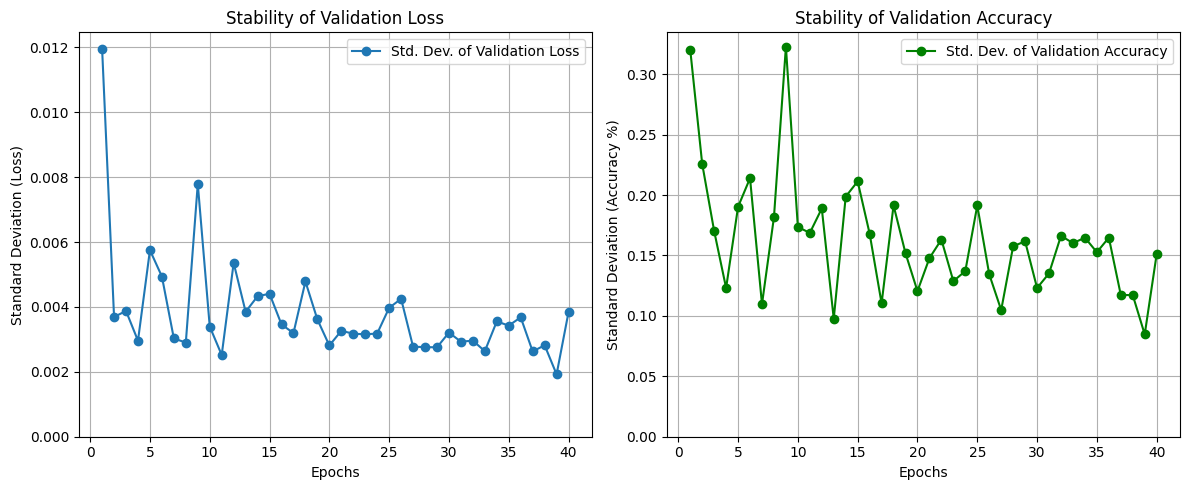

In [ ]:
epochs = range(1, len(std_val_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, std_val_loss, 'o-', label='Std. Dev. of Validation Loss')
plt.title('Stability of Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation (Loss)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(epochs, std_val_acc, 'o-', label='Std. Dev. of Validation Accuracy', color='green')
plt.title('Stability of Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation (Accuracy %)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

## 3. Hyper parameters tuning.
### 3.1. Learning rate tuning.

In [ ]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
max_val_acc = []

for lr in learning_rates:
    print(f"---learning rate = {lr}---\n\n")
    _ , _, _,val_accuracy,_ = training_infrastructure(train_dataset, val_dataset, 2, 64, lr, 64, 40)
    max_val_acc.append(max(val_accuracy))


---learning rate = 0.001---


Using cuda
Epoch: 1 / 40 | avg train loss: 2.1767 | train accuracy : 19.96|avg validation loss: 1.9816 | validation accuracy: 34.66 
Epoch: 2 / 40 | avg train loss: 1.7769 | train accuracy : 50.37|avg validation loss: 1.5633 | validation accuracy: 62.21 
Epoch: 3 / 40 | avg train loss: 1.3617 | train accuracy : 68.65|avg validation loss: 1.1791 | validation accuracy: 73.10 
Epoch: 4 / 40 | avg train loss: 1.0366 | train accuracy : 75.95|avg validation loss: 0.9199 | validation accuracy: 78.41 
Epoch: 5 / 40 | avg train loss: 0.8312 | train accuracy : 80.10|avg validation loss: 0.7617 | validation accuracy: 81.69 
Epoch: 6 / 40 | avg train loss: 0.7032 | train accuracy : 82.72|avg validation loss: 0.6607 | validation accuracy: 83.82 
Epoch: 7 / 40 | avg train loss: 0.6187 | train accuracy : 84.50|avg validation loss: 0.5919 | validation accuracy: 85.09 
Epoch: 8 / 40 | avg train loss: 0.5600 | train accuracy : 85.80|avg validation loss: 0.5427 | validation 

#### 3.1.1. Analysis

- Convergence Speed: As seen in the plot, convergence speed is directly tied to the learning rate.

    - `LR=0.001` : Converges extremely slowly. After 100 epochs, it only reached 93.75% accuracy, a level the other models reached in 10-15 epochs.

    - `LR=0.01` : Shows stable and steady convergence, reaching 96.86% accuracy. This is a good, safe baseline.

    - `LR=0.1` : Converges significantly faster than `0.01` and achieved the highest peak accuracy (97.36%). This is the optimal learning rate in this group.

- Stability:

    - `LR=1.0` : This rate is too high and unstable. The validation loss is erratic, jumping all over. This indicates the optimizer is overshooting the minimum and failing to converge properly.

    - `LR=0.1` and `LR=0.01` both show stable convergence, but `0.1` is more aggressive and finds a better minimum faster.

In [ ]:
optimal_lr = learning_rates[np.argmax(max_val_acc)]

print(f"Optimal Learning rate = {optimal_lr}\n")
max_val_acc


Optimal Learning rate = 0.1



[91.65714285714286, 96.28571428571429, 97.42857142857143, 40.378571428571426]

### 3.2. Architecture tuning.

#### 3.2.1. Number of layers tuning.

In [ ]:
number_of_layers = [2, 3, 4 , 5]
max_val_acc_nol = []

for nol in number_of_layers:
    print(f"---Number of layers = {nol}---\n\n")
    _ , _, _,val_accuracy,_ = training_infrastructure(train_dataset, val_dataset, nol, 64, optimal_lr, 64, 40)
    max_val_acc_nol.append(max(val_accuracy))

---Number of layers = 2---


Using cuda
Epoch: 1 / 40 | avg train loss: 0.3852 | train accuracy : 88.52|avg validation loss: 0.2301 | validation accuracy: 93.29 
Epoch: 2 / 40 | avg train loss: 0.1832 | train accuracy : 94.43|avg validation loss: 0.2261 | validation accuracy: 92.90 
Epoch: 3 / 40 | avg train loss: 0.1375 | train accuracy : 95.88|avg validation loss: 0.1544 | validation accuracy: 95.41 
Epoch: 4 / 40 | avg train loss: 0.1116 | train accuracy : 96.66|avg validation loss: 0.1875 | validation accuracy: 94.53 
Epoch: 5 / 40 | avg train loss: 0.0942 | train accuracy : 97.09|avg validation loss: 0.1442 | validation accuracy: 95.62 
Epoch: 6 / 40 | avg train loss: 0.0790 | train accuracy : 97.59|avg validation loss: 0.1351 | validation accuracy: 96.04 
Epoch: 7 / 40 | avg train loss: 0.0692 | train accuracy : 97.87|avg validation loss: 0.1264 | validation accuracy: 96.27 
Epoch: 8 / 40 | avg train loss: 0.0599 | train accuracy : 98.18|avg validation loss: 0.2925 | validation a

In [ ]:
optimal_NOL = number_of_layers[np.argmax(max_val_acc_nol)]

print(f"Optimal number of layers = {optimal_NOL}\n")

Optimal number of layers = 4



#### 3.2.2. Number of neurons per layer.

In [ ]:
number_of_neurons = [64, 128, 256, 512]
max_val_acc_non = []


for non in number_of_neurons:
    print(f"---number of neurons = {non}---\n\n")
    _ , _, _,val_accuracy,_ = training_infrastructure(train_dataset, val_dataset, optimal_NOL, non, optimal_lr, 64, 40)
    max_val_acc_non.append(max(val_accuracy))

---number of neurons = 64---


Using cuda
Epoch: 1 / 40 | avg train loss: 0.3844 | train accuracy : 87.98|avg validation loss: 0.2906 | validation accuracy: 91.10 
Epoch: 2 / 40 | avg train loss: 0.1628 | train accuracy : 95.04|avg validation loss: 0.2559 | validation accuracy: 92.09 
Epoch: 3 / 40 | avg train loss: 0.1218 | train accuracy : 96.29|avg validation loss: 0.2081 | validation accuracy: 93.69 
Epoch: 4 / 40 | avg train loss: 0.0970 | train accuracy : 96.95|avg validation loss: 0.1791 | validation accuracy: 94.70 
Epoch: 5 / 40 | avg train loss: 0.0783 | train accuracy : 97.59|avg validation loss: 0.1423 | validation accuracy: 95.66 
Epoch: 6 / 40 | avg train loss: 0.0678 | train accuracy : 97.84|avg validation loss: 0.1486 | validation accuracy: 95.68 
Epoch: 7 / 40 | avg train loss: 0.0570 | train accuracy : 98.17|avg validation loss: 0.1277 | validation accuracy: 96.41 
Epoch: 8 / 40 | avg train loss: 0.0502 | train accuracy : 98.37|avg validation loss: 0.1266 | validation

In [ ]:
optimal_NON = number_of_neurons[np.argmax(max_val_acc_non)]

print(f"Optimal number of neurons = {optimal_NON}\n")

Optimal number of neurons = 512



#### 3.2.3. Analysis

- Number of Layers: Performance peaked at 4 hidden layers . Adding a 5th layer provided no benefit and slightly hurt performance, likely due to overfitting and the added difficulty of training a deeper network (vanishing gradients). The 2-layer model was the least performant.

- Neurons per Layer: Performance peaked at 128 neurons . However, the performance doesn't really change much after that. The accuracy for 128, 256, and 512 neurons are all very close (97.98%, 97.86%, and 97.96% respectively). This suggests that once the model has sufficient capacity (more than 64 neurons), adding more neurons doesn't significantly impact the final accuracy.

In [ ]:
table_data = []

for nol, max_acc in zip(number_of_layers, max_val_acc_nol):
    table_data.append({
        "Parameter": "Number of Layers",
        "Value": nol,
        "Max Validation Accuracy (%)": round(max_acc, 2)
    })

for non, max_acc in zip(number_of_neurons, max_val_acc_non):
    table_data.append({
        "Parameter": "Neurons/Layer",
        "Value": non,
        "Max Validation Accuracy (%)": round(max_acc, 2)
    })

df = pd.DataFrame(table_data)

df = df.set_index(['Parameter', 'Value'])
display(df)

Max Validation Accuracy (%)
Parameter        Value                             
Number of Layers 2                            97.28
                 3                            97.59
                 4                            97.69
                 5                            97.54
Neurons/Layer    64                           97.57
                 128                          97.76
                 256                          97.88
                 512                          97.91

### 3.3. Batch size tuning.

In [ ]:
batch_sizes = [16, 32, 64, 128]
max_val_acc = []

for bs in batch_sizes:
    print(f"---Batch size = {bs}---\n\n")
    _ , _, _,val_accuracy,_ = training_infrastructure(train_dataset, val_dataset, optimal_NOL, optimal_NON, optimal_lr, bs, 40)
    max_val_acc.append(max(val_accuracy))

---Batch size = 16---


Using cuda
Epoch: 1 / 40 | avg train loss: 0.2553 | train accuracy : 92.08|avg validation loss: 0.1283 | validation accuracy: 96.14 
Epoch: 2 / 40 | avg train loss: 0.1040 | train accuracy : 96.82|avg validation loss: 0.0982 | validation accuracy: 97.01 
Epoch: 3 / 40 | avg train loss: 0.0672 | train accuracy : 97.90|avg validation loss: 0.1209 | validation accuracy: 96.26 
Epoch: 4 / 40 | avg train loss: 0.0493 | train accuracy : 98.40|avg validation loss: 0.0910 | validation accuracy: 97.43 
Epoch: 5 / 40 | avg train loss: 0.0377 | train accuracy : 98.77|avg validation loss: 0.0950 | validation accuracy: 97.46 
Epoch: 6 / 40 | avg train loss: 0.0273 | train accuracy : 99.14|avg validation loss: 0.0939 | validation accuracy: 97.51 
Epoch: 7 / 40 | avg train loss: 0.0209 | train accuracy : 99.35|avg validation loss: 0.0924 | validation accuracy: 97.67 
Epoch: 8 / 40 | avg train loss: 0.0182 | train accuracy : 99.41|avg validation loss: 0.1174 | validation accura

#### 3.3.1. Analysis

- Training Efficiency:

    - `BS=128`: This was the fastest to complete each epoch, as it required the fewest update steps.

    - `BS=16`: This was the slowest to complete each epoch, as it required 4x as many steps as `BS=64`.

- Final Performance: The results show an inverse relationship between batch size and final accuracy.

    - `BS=16` achieved the highest accuracy.

    - `BS=32` was slightly lower.

    - `BS=128` had the lowest accuracy.

- Gradient Noise: This trade-off is due to gradient noise.

    - Smaller batches `(16, 32)` introduce more noise into the gradient update. This noise can help the model escape "sharp" local minima and find a "flatter," more generalizable solution, leading to higher accuracy.

    - Larger batches `(128)` have a smoother (less noisy) gradient, which makes them converge quickly but to the nearest, "sharpest" minimum, which may not be the best one for generalization.

In [ ]:
optimal_BS = batch_sizes[np.argmax(max_val_acc)]

print(f"Optimal batch size = {optimal_BS}\n")
max_val_acc

Optimal batch size = 16



[98.2, 98.08571428571429, 97.9, 97.73571428571428]

# 4. Optimal model evaluation

In [ ]:
optimal_train_loss, optimal_train_acc, optimal_val_loss, optimal_val_acc, optimal_model = training_infrastructure(train_dataset, test_dataset, optimal_NOL, optimal_NON, optimal_lr, optimal_BS, 40)

Using cuda
Epoch: 1 / 40 | avg train loss: 0.2515 | train accuracy : 92.23|avg validation loss: 0.1210 | validation accuracy: 96.46 
Epoch: 2 / 40 | avg train loss: 0.1038 | train accuracy : 96.78|avg validation loss: 0.1216 | validation accuracy: 96.40 
Epoch: 3 / 40 | avg train loss: 0.0681 | train accuracy : 97.76|avg validation loss: 0.1119 | validation accuracy: 96.76 
Epoch: 4 / 40 | avg train loss: 0.0461 | train accuracy : 98.56|avg validation loss: 0.0886 | validation accuracy: 97.48 
Epoch: 5 / 40 | avg train loss: 0.0370 | train accuracy : 98.82|avg validation loss: 0.1068 | validation accuracy: 97.14 
Epoch: 6 / 40 | avg train loss: 0.0293 | train accuracy : 99.09|avg validation loss: 0.0839 | validation accuracy: 97.79 
Epoch: 7 / 40 | avg train loss: 0.0217 | train accuracy : 99.30|avg validation loss: 0.0859 | validation accuracy: 97.90 
Epoch: 8 / 40 | avg train loss: 0.0183 | train accuracy : 99.43|avg validation loss: 0.0907 | validation accuracy: 97.78 
Epoch: 9 / 40

In [ ]:
print(f"Max test accuracy: {max(optimal_val_acc):.2f}")

Max test accuracy: 98.39


# 5. Convolutional Neural Network model


Input: An image of size 28x28 pixels

First layer: Convolutional layer with 1 input channel, 16 different filters, 3x3 kernel size

Size stays the same because padding=1

Second Layer: Max Pooling layer with 2x2 kernel size and compress it to half the size

Size becomes 14x14 after pooling

Third Layer: Convolutional layer with 16 input channels, 32 different filters, 3x3 kernel size

Internally, we pool again to reduce size to 7x7

At the end of the third layer, we have 32 outputs * 7 * 7

Fully connected layers
Image will be flattened to 128 nodes

## 5.1. Model Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))  # First convolutional layer and ReLU activation
        x = self.pool1(x)          # Pooling layer
        x = F.relu(self.conv2(x))  # Second convolutional layer and ReLU activation
        x = self.pool1(x)          # Pooling layer again

        x = x.view(-1, 32 * 7 * 7) # Flatten the tensor for the fully connected layers

        x = F.relu(self.fc1(x))    # First fully connected layer and ReLU activation
        x = self.fc2(x)            # Second fully connected layer (output layer)

        return x

## 5.2. CNN Training

In [ ]:
LEARNING_RATE = 0.01
BATCH_SIZE = 64
NUM_EPOCHS = 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for CNN training")

cnn_model = CNN().to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

cnn_train_losses = []
cnn_train_accs = []
cnn_val_losses = []
cnn_val_accs = []

for epoch in range(NUM_EPOCHS):

    cnn_model.train() # Set to training mode
    current_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Using the same train_NN_loader from cell 10
    for images, labels in train_NN_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)

        loss = loss_function(outputs, labels)
        current_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation loop
    cnn_model.eval() # Set to evaluation mode
    current_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_NN_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = cnn_model(images)

            loss = loss_function(outputs, labels)
            current_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Plotting and logging
    avg_train_loss = current_train_loss / len(train_NN_loader)
    avg_val_loss = current_val_loss / len(val_NN_loader)

    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val

    cnn_train_losses.append(avg_train_loss)
    cnn_val_losses.append(avg_val_loss)
    cnn_train_accs.append(train_accuracy)
    cnn_val_accs.append(val_accuracy)

    print(f"CNN Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

Using cuda for CNN training
CNN Epoch: 1/40 | Train Loss: 1.8882 | Train Acc: 44.71% | Val Loss: 0.7002 | Val Acc: 77.38%
CNN Epoch: 2/40 | Train Loss: 0.4299 | Train Acc: 87.03% | Val Loss: 0.3836 | Val Acc: 87.86%
CNN Epoch: 3/40 | Train Loss: 0.3044 | Train Acc: 90.53% | Val Loss: 0.4221 | Val Acc: 86.00%
CNN Epoch: 4/40 | Train Loss: 0.2394 | Train Acc: 92.64% | Val Loss: 0.4359 | Val Acc: 85.44%
CNN Epoch: 5/40 | Train Loss: 0.1928 | Train Acc: 94.07% | Val Loss: 0.2676 | Val Acc: 91.19%
CNN Epoch: 6/40 | Train Loss: 0.1603 | Train Acc: 95.02% | Val Loss: 0.1546 | Val Acc: 95.31%
CNN Epoch: 7/40 | Train Loss: 0.1369 | Train Acc: 95.81% | Val Loss: 0.1521 | Val Acc: 95.31%
CNN Epoch: 8/40 | Train Loss: 0.1183 | Train Acc: 96.33% | Val Loss: 0.1232 | Val Acc: 96.25%
CNN Epoch: 9/40 | Train Loss: 0.1052 | Train Acc: 96.81% | Val Loss: 0.1845 | Val Acc: 93.98%
CNN Epoch: 10/40 | Train Loss: 0.0941 | Train Acc: 97.10% | Val Loss: 0.1477 | Val Acc: 95.03%
CNN Epoch: 11/40 | Train Loss: 

## 5.3 Plotting

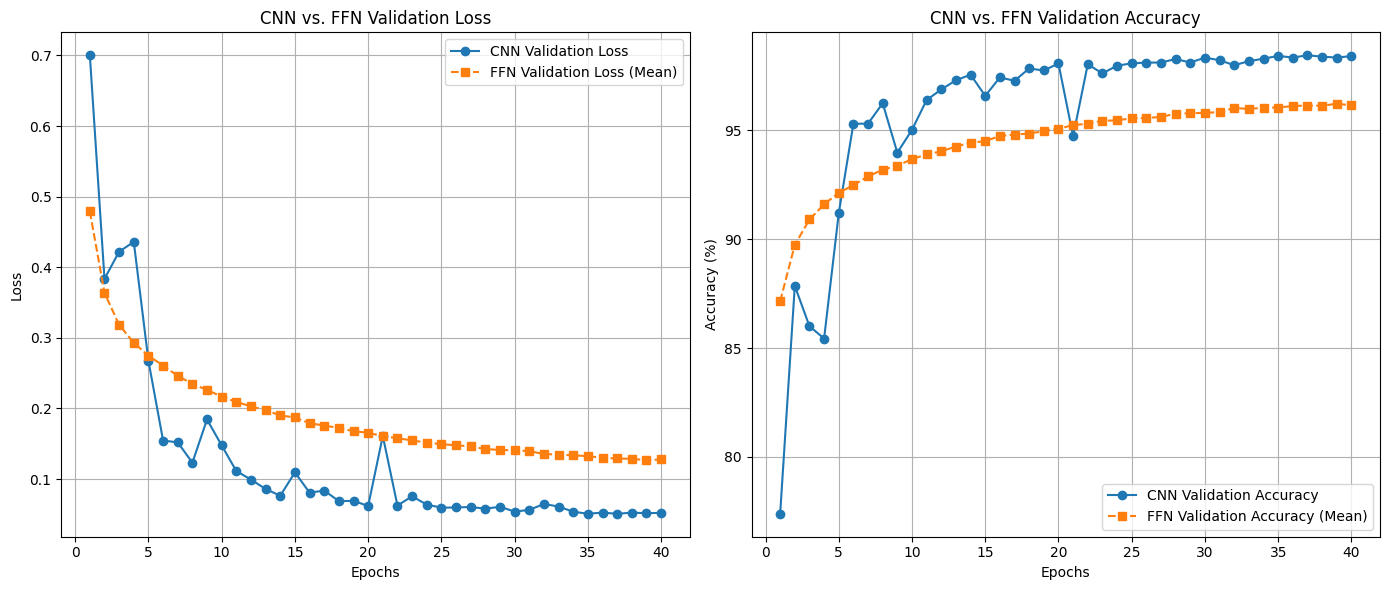

In [ ]:
# Part D1: CNN vs. FFN Comparison Plots

# Get the FFN's mean performance from cell 30
ffn_val_loss_mean = mean_val_loss[:NUM_EPOCHS]
ffn_val_acc_mean = mean_val_acc[:NUM_EPOCHS]

epochs_cnn = range(1, len(cnn_val_losses) + 1)

plt.figure(figsize=(14, 6))

# Plot 1: Validation Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs_cnn, cnn_val_losses, 'o-', label='CNN Validation Loss')
plt.plot(epochs_cnn, ffn_val_loss_mean, 's--', label='FFN Validation Loss (Mean)')
plt.title('CNN vs. FFN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs_cnn, cnn_val_accs, 'o-', label='CNN Validation Accuracy')
plt.plot(epochs_cnn, ffn_val_acc_mean, 's--', label='FFN Validation Accuracy (Mean)')
plt.title('CNN vs. FFN Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Analysis of the benefit of spatial feature learning

Spatial feature learning in CNNs allow the model to capture local patterns in images, such as edges, textures, and shapes. It prevents overfitting since the filter passes over the image, learning only the important features. After that, the pooling layers reduce the spatial dimensions, which doesn't just decrease computational load but also makes the model only retain the important features which makes it more general.

# 6. Dropout Analysis and Batch Normalization

### 6.1. Define FFN with Dropout and BatchNorm layers

This class inherits from the FeedForwardNN class defined earlier and adds dropout layers after each hidden layer.

In [ ]:
class FeedForwardNN_Dropout(FeedForwardNN):
    def __init__(self, input_size, number_hidden_layers, hidden_size, output_size, dropout_rate):
        super().__init__(input_size, number_hidden_layers, hidden_size, output_size)

        self.dropouts = nn.ModuleList()
        for _ in range(number_hidden_layers): # One dropout for each hidden layer
            self.dropouts.append(nn.Dropout(dropout_rate))

    # Override the forward method
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten as it is done in the parent class

        # Loop through hidden layers and their corresponding dropouts
        for i in range(len(self.layers) - 1): # All layers except the final output layer

            # Pass through Linear layer, then ReLU
            x = self.layers[i](x)
            x = F.relu(x)

            # Apply dropout
            # This should only be active during model.train()
            x = self.dropouts[i](x)

        # Apply output layer (no dropout)
        x = self.layers[-1](x)
        return x

## 6.2 Training FFN With Dropout

Using the optimal parameters from Part C as the base

In [ ]:
LEARNING_RATE = optimal_lr
NUM_EPOCHS = 40
HIDDEN_LAYERS = optimal_NOL
HIDDEN_SIZE = optimal_NON
INPUT_SIZE = 784
OUTPUT_SIZE = 10

dropout_rates = [0.1, 0.3, 0.5, 0.7]
dropout_results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for Dropout analysis")

loss_function = nn.CrossEntropyLoss()

# Loop over each dropout rate
for rate in dropout_rates:
    print(f"--- dropout rate = {rate} ---")

    model = FeedForwardNN_Dropout(INPUT_SIZE, HIDDEN_LAYERS, HIDDEN_SIZE, OUTPUT_SIZE, rate).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(NUM_EPOCHS):

        model.train() # Training mode, adds dropout
        current_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # We use train_NN_loader (BS=64)
        for images, labels in train_NN_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            current_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Validation
        model.eval() # Disables dropout
        current_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_NN_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = loss_function(outputs, labels)
                current_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_train_loss = current_train_loss / len(train_NN_loader)
        avg_val_loss = current_val_loss / len(val_NN_loader)
        train_accuracy = 100 * correct_train / total_train
        val_accuracy = 100 * correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Rate: {rate} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # Save the results object for this rate
    dropout_results[rate] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    }

Using cuda for Dropout analysis
--- dropout rate = 0.1 ---
Epoch: 1/40 | Rate: 0.1 | Val Loss: 0.2114 | Val Acc: 93.59%
Epoch: 2/40 | Rate: 0.1 | Val Loss: 0.1636 | Val Acc: 94.79%
Epoch: 3/40 | Rate: 0.1 | Val Loss: 0.1118 | Val Acc: 96.47%
Epoch: 4/40 | Rate: 0.1 | Val Loss: 0.0936 | Val Acc: 97.28%
Epoch: 5/40 | Rate: 0.1 | Val Loss: 0.0915 | Val Acc: 97.29%
Epoch: 6/40 | Rate: 0.1 | Val Loss: 0.0968 | Val Acc: 97.23%
Epoch: 7/40 | Rate: 0.1 | Val Loss: 0.1757 | Val Acc: 95.13%
Epoch: 8/40 | Rate: 0.1 | Val Loss: 0.0856 | Val Acc: 97.71%
Epoch: 9/40 | Rate: 0.1 | Val Loss: 0.0817 | Val Acc: 97.69%
Epoch: 10/40 | Rate: 0.1 | Val Loss: 0.0921 | Val Acc: 97.60%
Epoch: 11/40 | Rate: 0.1 | Val Loss: 0.0830 | Val Acc: 97.89%
Epoch: 12/40 | Rate: 0.1 | Val Loss: 0.0972 | Val Acc: 97.58%
Epoch: 13/40 | Rate: 0.1 | Val Loss: 0.0849 | Val Acc: 97.96%
Epoch: 14/40 | Rate: 0.1 | Val Loss: 0.0852 | Val Acc: 97.95%
Epoch: 15/40 | Rate: 0.1 | Val Loss: 0.0896 | Val Acc: 97.84%
Epoch: 16/40 | Rate:

## 6.3 Plots

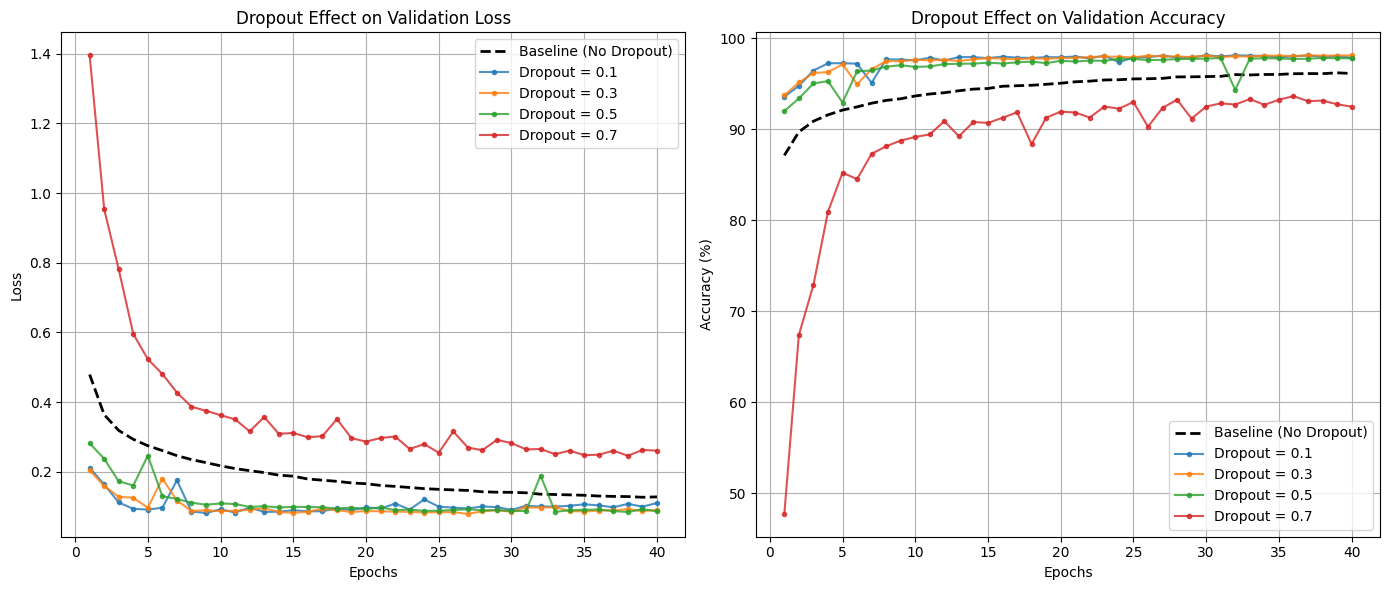

In [ ]:
baseline_val_loss = mean_val_loss[:NUM_EPOCHS]
baseline_val_acc = mean_val_acc[:NUM_EPOCHS]

epochs = range(1, NUM_EPOCHS + 1) # 1-based indexing

plt.figure(figsize=(14, 6)) # Expand it

# Validation loss comparison
plt.subplot(1, 2, 1)
# Plot the baseline (no dropout)
plt.plot(epochs, baseline_val_loss, 'k--', label='Baseline (No Dropout)', linewidth=2)

# Plot each dropout rate
for rate in dropout_rates:
    plt.plot(epochs, dropout_results[rate]['val_loss'], 'o-', label=f'Dropout = {rate}', markersize=3, alpha=0.8)

plt.title('Dropout Effect on Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Validation accuracy comparison
plt.subplot(1, 2, 2)
# Baseline (no dropout)
plt.plot(epochs, baseline_val_acc, 'k--', label='Baseline (No Dropout)', linewidth=2)

# Plot each dropout rate curve
for rate in dropout_rates:
    plt.plot(epochs, dropout_results[rate]['val_acc'], 'o-', label=f'Dropout = {rate}', markersize=3, alpha=0.8)

plt.title('Dropout Effect on Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()